---

### Project 1 - Housing Pricing Prediction 
### Part 2: Machine Learning - First Models: Linear Regression, Knn, Decision Tree

---

In this Part of the Project we will build 3 Regression Models: a Linear Regression (Benchmark), a K-Neighbor Regressor and a Decision Tree Regressor (both with hyperparameter optimization).  
Metrics used:  $R^2$ (scale free, for Model performance) and $RMSE$ (target variable unit, for standard deviation of residuals measurement).  
The dataset used is Properati's version analized and filtered in Part 1.  

Notebook content:

1. Data Preparation
2. Models Training, evaluation and error analysis
3. Validation Curves
4. Model selection and conclusion

### 1. Data Preparation
---



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

sns.set() 

In [2]:
warnings.simplefilter('ignore')

Import dataset.

In [3]:
df = pd.read_csv('datasets/ds_final.csv')

In [4]:
ds = df.copy()

In [5]:
ds.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,lat,lon,price,apartment,condominium,house
0,2.0,1.0,1.0,68.0,59.0,-34.603683,-58.381557,149000.0,1,0,0
1,2.0,1.0,1.0,50.0,44.0,-34.630349,-58.417223,115000.0,1,0,0
2,2.0,1.0,1.0,31.0,31.0,-34.608246,-58.444262,75000.0,1,0,0
3,1.0,1.0,1.0,22.0,22.0,-34.603890,-58.410998,48000.0,1,0,0
4,2.0,1.0,1.0,45.0,45.0,-34.626240,-58.462078,95000.0,1,0,0


Features 'X' and Target 'y' selection.

In [6]:
X = ds.drop(columns='price')
y = ds['price']

print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (64482, 10)
y shape: (64482,)


Train/Test split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [8]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape)) 
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (48361, 10)
y_train shape: (48361,)
X_test shape: (16121, 10)
y_test shape: (16121,)


Scaling data.

In [9]:
scaler = StandardScaler()

In [10]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2. Models Training, evaluation and error analysis
---

Defining R² and RMSE calculation function. 

In [11]:
# def model_results(X_train, y_train, X_test, y_test, model, name):
def model_results(model, name):
    
    pred_model_train = model.predict(X_train)
    pred_model_test = model.predict(X_test)

    print(f'{name}:')
    print('R² in Train Set: {:.4f}'.format(model.score(X_train, y_train)))
    print('RMSE in Train Set: {:.4f}'.format(np.sqrt(mean_squared_error(pred_model_train, y_train))))
    print('R² in Test Set: {:.4f}'.format(model.score(X_test, y_test)))
    print('RMSE in Test Set: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, pred_model_test))))  

Defining function for:
1. Models error calculation. 
2. Error distribution plotting.
3. Real values vs Predicted values plotting.

In [12]:
def model_graphs(model, name):
    
    model.fit(X_train ,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
       
    plt.figure(figsize = (12,6))
    plt.suptitle(f'Model: {name}', fontsize=18)

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 30, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 30, label = 'test')
    plt.title('Error distribution', fontsize=16)
    plt.xlabel('Error', size=13)
    plt.ylabel('Density', size=13)
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.title('Price dispersion', fontsize=16)
    plt.xlabel('Real values', size=13)
    plt.ylabel('Predicted values', size=13)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 

    plt.show()

Plotting function for Real and Predicted Price values distribution.

In [13]:
def model_prediction_dist(model, name):

    prediction = model.predict(X_test)

    plt.figure(figsize=(11,6))

    sns.distplot(y_test, hist=True, kde=False)
    sns.distplot(prediction, hist=True, kde=False)
    plt.legend(labels=['Price real values', 'Price predicted values'], prop={"size":12})
    plt.title(f'Model: {name}\n Real values vs. Predicted values', size=17)
    plt.xlabel('Price', size=13)
    plt.ylabel('Properties', size=13)
    plt.ticklabel_format(axis="x", style="plain", scilimits=(0,0))

#     plt.xlim(0,1750000)

Grid Search results plotting function.

In [14]:
def grid_results(grid):
    
    print('Best Hiperparameters:', grid.best_params_)
    print('CV mean results:', grid.best_score_)

Custom Validation Curve plotting function.

In [15]:
sns.set_style("darkgrid")

In [16]:
def custom_val_curve(model_name, parameter_name, parameter_values):
    size=[]
    rmse_ac_test=[]
    rmse_ac_train=[]
    rmse_ac_diff=[]
    
    for n in parameter_values:
        size.append(n)
        if model_name=='Knn':
            model_ = KNeighborsRegressor(n_neighbors=n) # erased: " ,algorithm='auto' "
        elif model_name=='Decision Tree':
            model_ = DecisionTreeRegressor(max_depth=n, random_state=42)
            
        model_.fit(X_train, y_train)
        y_train_pred = model_.predict(X_train)
        y_test_pred =  model_.predict(X_test)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))   

        dif=rmse_test-rmse_train
        rmse_ac_test.append(rmse_test)
        rmse_ac_train.append(rmse_train)
        rmse_ac_diff.append(dif) 
        
    data=pd.DataFrame({f'{parameter_name}':size,'rmse_train':rmse_ac_train, 'rmse_test':rmse_ac_test,'rmse_diff':rmse_ac_diff})

    f, ax = plt.subplots(figsize=(11, 7))

    ax1=sns.lineplot(x = f"{parameter_name}", y = "rmse_train", data = data, linewidth=2, color='b', marker="o", markersize=8)
    ax1=sns.lineplot(x = f"{parameter_name}", y = "rmse_test", data = data, linewidth=2, color='r', marker="o", markersize=8)
    ax1.legend(["train","test"],borderpad=1)

    plt.title(f"Validation Curve Model {model_name}", fontsize=17)
    plt.xticks(np.arange(0, 41, 5))
    plt.xlabel(f"{parameter_name}", fontsize=13)
    plt.ylabel("RMSE", fontsize=13)

    plt.show()
#     return data

### Model 1: Linear Regression 

Create and train the model.

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Model evaluation.

In [18]:
model_results(lr, 'Linear Regression')

Linear Regression:
R² in Train Set: 0.6994
RMSE in Train Set: 51694.9821
R² in Test Set: 0.6922
RMSE in Test Set: 51883.2409


The model is underfitting (high bias). We won't be able to tune it given that the algorithm does not have modifiable hyperparameters. The similarity between the model performance in train and test sets confirms the high bias.

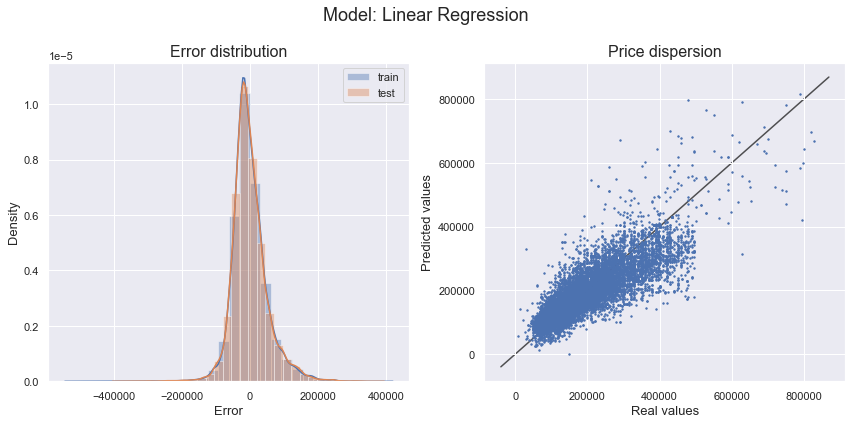

In [125]:
model_graphs(lr, 'Linear Regression')

**Figure 1.** Linear Regression Model error distribution (both sets) and Price predicted vs real values dispersion (test set).

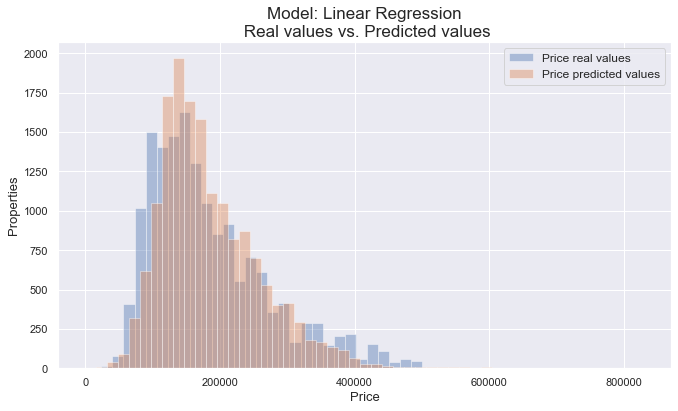

In [20]:
model_prediction_dist(lr, 'Linear Regression')

**Figure 2.** Price real and Linear Regression Model predicted values distributions (test set).

Errors distribution is approximately gaussian and is centered in 0 on both sets.  
Points in the real and predicted values dispersion graph scatter from the diagonal after 500.000.  
Train and test sets values histograms show right skewed but different distributions.

### Model 2: KNN 

Hyperparameters grid search.

In [18]:
knn_grid = {'n_neighbors':[1,2,3,4,5]}

In [81]:
knn = KNeighborsRegressor()

In [19]:
knn_gs = GridSearchCV(knn, knn_grid, cv=5)

In [20]:
knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5]})

Grid search check.

In [21]:
grid_results(knn_gs)

Best Hiperparameters: {'n_neighbors': 3}
CV mean results: 0.8548842121128786


Model building.

In [21]:
knn_t = KNeighborsRegressor(n_neighbors= 3)
knn_t.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

Model evaluation.

In [22]:
model_results(knn_t, 'KNN')

KNN:
R² in Train Set: 0.9388
RMSE in Train Set: 23327.5656
R² in Test Set: 0.8674
RMSE in Test Set: 34054.4376


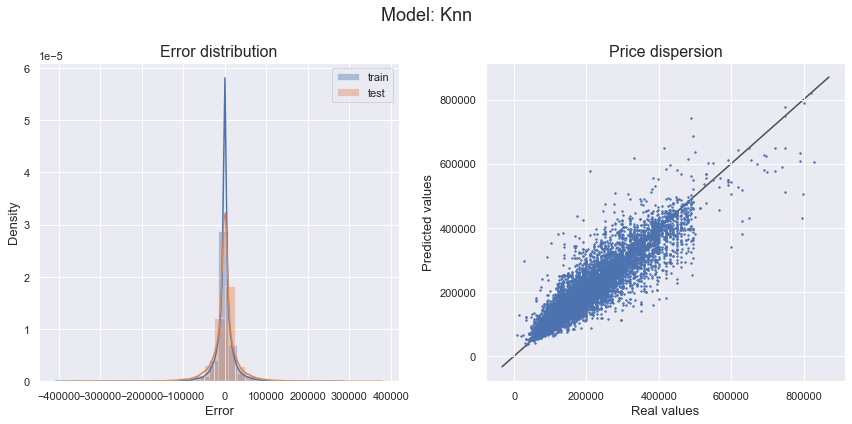

In [127]:
model_graphs(knn_t, 'Knn')

**Figure 3** - KNN Regression Model error distribution (both sets) and Price predicted vs real values dispersion (test set).

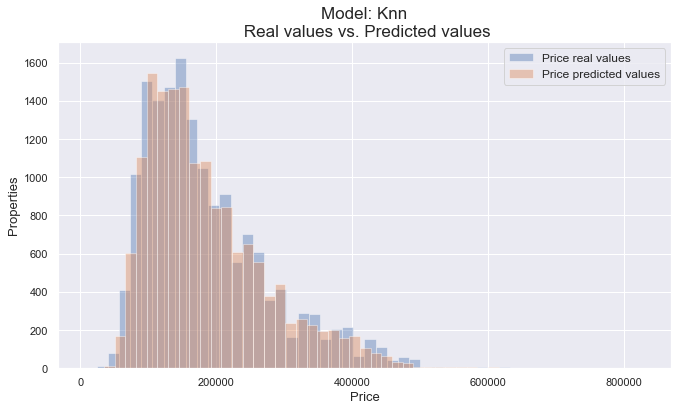

In [123]:
model_prediction_dist(knn_t, 'Knn')

**Figure 4.** Price real and KNN Regression Model predicted values distributions (test set).

Errors distribution is again approximately gaussian and centered in 0 on both sets.  
Points in the dispersion graph also scatter from the diagonal after 500.000 but not as much as the Linear Regression.  
The sets histogram shows similar right skewed distributions.

### Model 3: Decision Tree

For analysis purposes we will only tune the `max_depth` parameter. In Part 3 of the project we will train more complex models with multiparameters grid search. 

In [40]:
tree_grid = {'max_depth': [3,5,10,13,17,20,25]}

In [41]:
tree = DecisionTreeRegressor(random_state=42)

In [42]:
tree_gs = GridSearchCV(tree, tree_grid, cv=5)

In [43]:
tree_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [3, 5, 10, 13, 17, 20, 25]})

In [44]:
grid_results(tree_gs)

Best Hiperparameters: {'max_depth': 20}
CV mean results: 0.8374096512826261


In [112]:
tree_t = DecisionTreeRegressor(max_depth=20, random_state=42)

In [113]:
tree_t.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, random_state=42)

In [114]:
model_results(tree_t, 'Decision Tree')

Decision Tree:
R² in Train Set: 0.9896
RMSE in Train Set: 9635.1638
R² in Test Set: 0.8471
RMSE in Test Set: 36568.0385


Model shows much better results in the Train set, a clearly sign of overfitting (high variance).

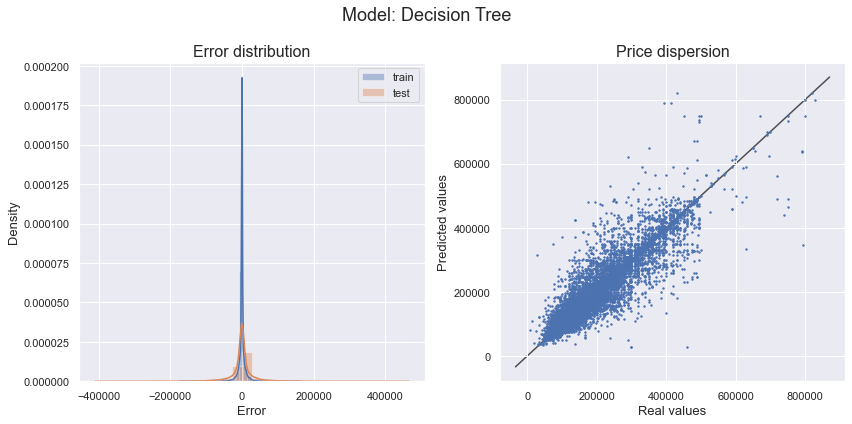

In [128]:
model_graphs(tree_t, 'Decision Tree')

**Figure 6** - Decision Tree Regression Model error distribution (both sets) and Price predicted vs real values dispersion (test set).

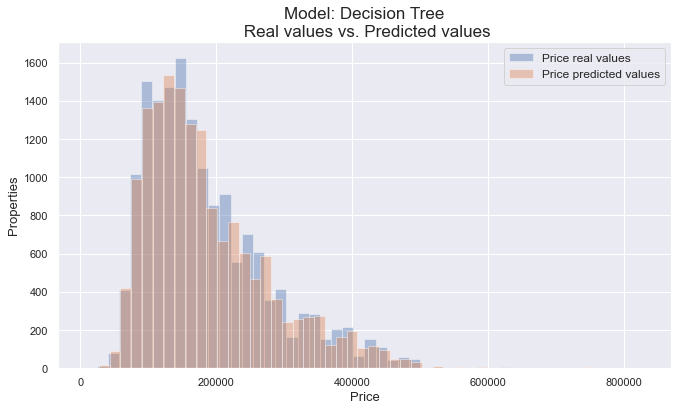

In [120]:
model_prediction_dist(tree_t, 'Decision Tree')

**Figure 7.** Price real and Decision Tree Regression Model predicted values distributions (test set).

Errors distribution is approximately gaussian and centered in 0 on both sets.  
Points in the dispersion graph are again in this model scattered from the diagonal after 500.000 and we can see more overvaluation cases than in the Knn model.  
The train and test sets values distributions show are similar and right skewed.

### 3. Validation Curves
---

### Knn

In [127]:
knn_parameter_values = [1,3,4,5,7,9,11,13,15,17,20,30,40]

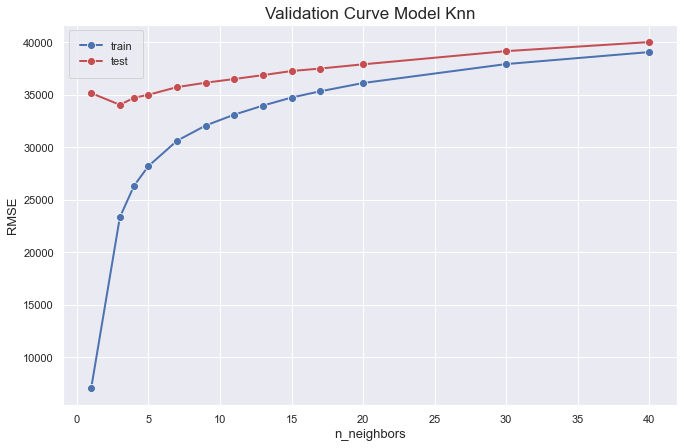

In [128]:
custom_val_curve('Knn', 'n_neighbors', knn_parameter_values)

**Figure 5.** Validation curve: Knn Models error for k-neighbors different values.

At the left of **Figure 5** we can see that low values for k generate more complex models that tend to overfit (high variance), this is shown by the distance between the curves in this part of the graph.  To the right side, for higher k values, models became simpler and tend to underfit (high bias), what is clearly visible in the error increase in both sets and the proximity of the curves.  
The chosen k value (3) was not as low such that our model is in the overfitting zone, neither as high that it simplificates too much and gets in the underfitting zone.

### Decision Tree

In [ ]:
tree_parameter_values=[1,3,4,5,7,8,9,11,12,13,14,15,16,17,18,19,20,30,40]

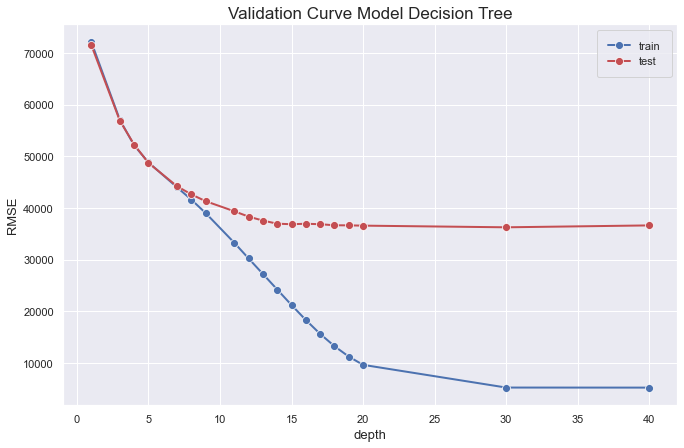

In [141]:
custom_val_curve('Decision Tree', 'depth', tree_parameter_values)

**Figure 8.** Validation curve: Decision Tree Models error for depth different values.

What **Figure 8** shows is that what with the Decision Tree model the opposite happens: at the left of the graph, for lower 'max_depth' values, models are simpler ant tend to underfit (high bias), what is seen in the curves closeness. To the right, with higher depth values, models became more complex and tend to overfit (high variance), visible in the distance between the two curves. Results stabilize in the test set after 'max_depth'=20, so values should not be higher than that making models unnecessarily complex.

### 4. Model selection and conclusion
---

In [129]:
formt = lambda x: float("{:.4f}".format(x))

regressor = ['Linear Regression', 'Knn', 'Decision Tree']
models = [lr, knn_t, tree_t]

R2_Train, R2_Test, RMSE_Train, RMSE_Test = [], [], [], []

for m in models:
    R2_Train.append(formt(m.score(X_train, y_train)))
    R2_Test.append(formt(m.score(X_test, y_test)))
    RMSE_Train.append(formt(np.sqrt(mean_squared_error(m.predict(X_train), y_train))))
    RMSE_Test.append(formt(np.sqrt(mean_squared_error(y_test, m.predict(X_test)))))

results = pd.DataFrame({'R² Train':R2_Train, 'R² Test':R2_Test,'RMSE Train':RMSE_Train,'RMSE Test':RMSE_Test}, index=regressor)
    
results

,R² Train,R² Test,RMSE Train,RMSE Test
Linear Regression,0.6994,0.6922,51694.9821,51883.2409
Knn,0.9388,0.8674,23327.5656,34054.4376
Decision Tree,0.9896,0.8471,9635.1638,36568.0385


Both Knn and Decision Tree models outperformed the Linear Regression benchmark model which was clearly underfitting. On the other hand, from this two models, the Decision Tree was overfitting, making the Knn our winner with a $R^2$=0.8674, what indicates that almost 87% of the prices variance can be predicted, and a $RMSE$=34054.4376 what is an acceptable (but not optimal) value considering estates average price.  
The Knn outperformance could be seen in the dispersion graphs analysis were the Decision Tree showed more disperse points after the value 500.000.

We will build more powerful models with ensemble algorithms to improve this results in Part 3 of the project.